# 3. Multi-Scenario Multi-objective Robust Decision Making optimization

This notebook contains the Multi-Scenario Multi-objective Robust Decision Making (MORDM) optimization process. First, the wort-case reference scenarios are identified. Second, the minimum and maximum values for the outcomes are estimated. Third, the previous are used to perform Multi-Scenario MORDM optimization.

This notebook is concerned with the identification of the optimal values for an efficient and representative optimisation. The objective outcomes to be optimized aim to minimize the aggregated Expected Annual Damage, Dike Investment Costs, and Expected Number of Deaths. The other outcomes RfR Investment Costs and Evacuation Costs were not minimized because it is in the interest of the Environmental Interest group to consider policies in which RfR and Evacuation are implemented.

Besides looking for a policy that protects the interests of the client, it is also important to search for the most favourable and acceptable policy for other involved actors. In light of this, the MORDM framework can search for promising strategies using a a Many-Objective Evolutionary Algorithm (MOEA) in multiple reference scenarios (Kasprzyk et al.2013; Watson and Kasprzyk2017; Bartholomew and J. H. Kwakkel2020).

## 3.1 Worst-case reference scenarios

In the first step, we identify which are the top 5 worst-case scenarios in terms of Expected Annual Damage and Expected Number of Deaths from the base case. Finding effective policies under those scenarios will guarantee to a certain extent that they will also be effective under the rest of scenarios.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)
from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator,
                           Constraint, Policy, Scenario)

from problem_formulation import get_model_for_problem_formulation

import time

In [2]:
# load the base case results
experiments, outcomes = load_results('../results/basecase_results.tar.gz') 
outcomes_df = pd.DataFrame.from_dict(outcomes)

In [3]:
# load the experiment results that are within the established threshold in the Scenario Discovery section in the base case analysis.
# These are the ones that are simultaneously among the 25% of the worst outcomes for death and damage costs as well as 
# being among the 50% of the worst outcomes with high disadvantaged locations.
y3 = pd.read_csv('../results/boolean_worst_scenarios.csv').iloc[:, 1:]

# Convert Series to a list
y = np.array(y3).squeeze()

In [4]:
# Filter out experiments in the base case result which obey the established threshold
experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

In [5]:
# function to aggregate over time and locations
def aggregate_df(df):
    df_aggregate_time = pd.DataFrame()
    df_aggregate_time_location = pd.DataFrame()
    locations = ['A.1', 'A.2', 'A.3', 'A.4', 'A.5']
    step = ['0', '1', '2']
    metrics = ['Expected Annual Damage', 'Dike Investment Costs', 'Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs']
    
    for metric in metrics:
        if metric == "RfR Total Costs" or metric == "Expected Evacuation Costs":

            columns = [metric + ' ' + time for time in step]

            df_aggregate_time_location[metric + ' time aggregate'] = df[columns].sum(axis=1)
        else:
            for location in locations:
                columns = [location + '_' + metric + ' ' + time for time in step]

                df_aggregate_time[location + '_' + metric + ' time aggregate'] = df[columns].sum(axis=1)
            
            columns_locations = [location + '_' + metric + ' time aggregate' for location in locations]
            df_aggregate_time_location[metric + ' time location aggregate'] = df_aggregate_time[columns_locations].sum(axis=1)
                    

    return df_aggregate_time, df_aggregate_time_location

In [6]:
# Aggregate the outcome values
df_agg_t, df_agg_tl = aggregate_df(outcomes_df)

In the next step we select the worst case scenarios over which we will optimize. In line with the maximin criterion, we rank all the different columns in the outcomes dataframe from highest to lowest value using eually weighted integer ranking. Then, we sum up the rank integer across all KPIs that belong to the same acenario and chose the scenarios which have the highest rank, i.e. the ones that perform the worst.  Specifically, 10 KPIs were ranked, being the time-aggregated expected number of deaths and expected damage costs. The other KPIs were not considered as the scenario discovery was performed on the base case and hence all policy costs will be zero.

In [7]:
# Given that we're ranking on the base case, the dike investment costs are zero. Therefore, we drop those columns.
dike_inv = ['A.1_Dike Investment Costs time aggregate', 'A.2_Dike Investment Costs time aggregate', 
            'A.3_Dike Investment Costs time aggregate', 'A.4_Dike Investment Costs time aggregate', 'A.5_Dike Investment Costs time aggregate']

df_agg_t.drop(columns=dike_inv, inplace=True)

In [8]:
# We rank each column and sum over each row value to obtain the rank of each scenario for Expected annual damage and Expected number of deaths
rank_df = pd.DataFrame()
for column in df_agg_t.columns:
    rank_df[column] = df_agg_t[column].rank()

rank_df['Final rank'] = rank_df.sum(axis=1)

In [9]:
# In order to sort out the values for the top 5 worst scenarios, we retrieve their index to then filter them out from the experiments 
worst_5_df = rank_df.sort_values(by='Final rank',ascending=False).head()
worst_5_ind = list(worst_5_df.index)

# Finally, we filter the worst scenarios out and only get back the first 19 columns, which correspond to the uncertain external factors in each scenario
scenarios_df = experiments_of_interest.iloc[worst_5_ind,:19]
indexes_scenarios = scenarios_df.index.to_list()
indexes_scenarios

[3794, 2761, 1322, 4347, 1009]

In [10]:
# Specify the scenarios in the workbench
scenarios = [Scenario(f"{index}", **row) for index, row in scenarios_df.iterrows()]

## 2. Estimation of minimum and maximum values

Now that we have the values of the uncertain external factors that correspond to the top 5 worst case scenarios, the only missing thing before we can start optimizing is the estimation of the minimum and maximum values of the KPIs we will optimize. These values are needed for the two following reason:
1. Determine the $\epsilon$ values for the $\epsilon-NSGAII$ grid
2. Determine the Hypevolume space


In [11]:
# Import the maximum and minimum values found across performing experiments for 100 policies across 400 scenarios in the policy lever exploration
import pickle
with open('../results/min_max_range_basecase.pickle', 'rb') as f:
    max_range_bc, min_range_bc = pickle.load(f)
with open('../results/min_max_range_randompolicies.pickle', 'rb') as f:
    max_range_rp, min_range_rp = pickle.load(f)

In [12]:
max_range = pd.concat([max_range_bc, max_range_rp], axis=1)
min_range = pd.concat([min_range_bc, min_range_rp], axis=1)

In [13]:
max_range = max_range.max(axis=1)
min_range = min_range.min(axis=1)

# Given that we are not optimizing over RfR Total Costs we are not interested in its maximum and minimum values
max_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)
min_range.drop(labels=['RfR Total Costs time aggregate'], inplace=True)

# Similarly, given that we are not optimizing over Expected Evacuation Costs we are not interested in its maximum and minimum values
max_range.drop(labels=['Expected Evacuation Costs time aggregate'], inplace=True)
min_range.drop(labels=['Expected Evacuation Costs time aggregate'], inplace=True)

In [14]:
# We can now see what are the values
max_range, min_range

(Expected Annual Damage time location aggregate       6.790428e+09
 Dike Investment Costs time location aggregate        9.334020e+08
 Expected Number of Deaths time location aggregate    5.855678e+00
 dtype: float64,
 Expected Annual Damage time location aggregate       0.0
 Dike Investment Costs time location aggregate        0.0
 Expected Number of Deaths time location aggregate    0.0
 dtype: float64)

## 3. Execute Multi-Scenario MORDM

Everything is now ready to optimize over the selected KPIs. Given that we don't want to optimize over all the outcomes defined in the original problem formulation, we created an alternative problem formulation (problem_formulation_altered). There are two main differences from the original:
1. It only contains Expected Annual Damage,  Dike Investment Costs, and Expected Number of Deaths as outcomes
2. The user can directly input the maximum and minium values for the expected_range in the order specified in 1.

Besides optimizing for a policy that protects the interests of the client, it is also important to search for the most favourable and acceptable policy for other involved actors, especially Rijkswaterstaat and Delta Commission given they have veto power. Therefore, a constraint has been set on the Expected Number of Deaths by which the experiment outcomes cannot be above 0.01\% * 3 time stages * 5 locations = 0.15\% = max_num_deaths. This constraints look to meet the requirement set by the Delta Commission by which there cannot be more than 0.01\% deaths per location and time stage. As a consequence of requiring to aggregate the outcomes, it is possible that this constraint is not met in the specific locations and outcomes, but at least ensures that overall this condition is met.

In [15]:
from problem_formulation_altered import get_model_for_problem_formulation_altered

In [16]:
# Initialise the altered formulation with the maximum and minimum ranges
dike_model, planning_steps = get_model_for_problem_formulation_altered(min_range,max_range)

deaths = ['Expected Number of Deaths']

max_num_deaths = 0.0001 * 3 * 5

# Adding the constraint for the allowed maximum number of deaths defined by the Delta Commission. By setting this as a constraint, the optimization will not
# return policies that do not meet this criterion.
constraints = [Constraint("Max number of deaths", outcome_names=deaths,
                          function=lambda x:max(0, x-max_num_deaths))]

In [17]:
## This cell contains the code to run the optimization. Results were saved and therefore it is commented out.


# ema_logging.log_to_stderr(ema_logging.INFO)

# The Hypervolume space has already been defined in the get_problem_formulation_altered function
# convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
#                        EpsilonProgress()]

# nfe = 7500
# results_deep = []
# convergence_all = []

# for scenario in scenarios:
#     with MultiprocessingEvaluator(dike_model) as evaluator:
#         results_runs, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
#                                         epsilons=[1e7, 1e6, 0.00001],
#                                         convergence=convergence_metrics, reference=scenario, constraints=constraints)
                                        
        
#         results_deep.append(results_runs)
#         convergence_all.append(convergence)

# from ema_workbench import save_results

# for i in range(len(results_deep)):
#     save_results((results_deep[i], convergence_all[i]), f'../results/mordm_7500_rp_scenario{i}.tar.gz')

The values for the $\epsilon$ have been iteratively determined by performing several short runs and studying the amount of solutions obtained by decreasing the maximum values for each outcome in 2 orders of magnitude. Closer attention was payed to the $\epsilon$ value for Expected Number of Deaths as we were interested in finding multiple optimal policies that obeyed the threshold. For that reason, the chosen $\epsilon$ is one order of magnitude lower than the constraint value.

Multi-Scenario MORDM succesfully found 42 policies that met the requirements. These policies are not evenly optimal, and trade-offs will need to be taken. To analyse the results in more depth, the notebook "Reevaluation" analyses the found policies under a larger space of deep uncertainty.

In [18]:
# We can now load the saved results
from ema_workbench import load_results

results_deep = []
convergence_all = []

for i in range(5):
    result, convergence = load_results(f'../results/mordm_7500_rp_scenario{i}.tar.gz')
    results_deep.append(result)
    convergence_all.append(convergence)

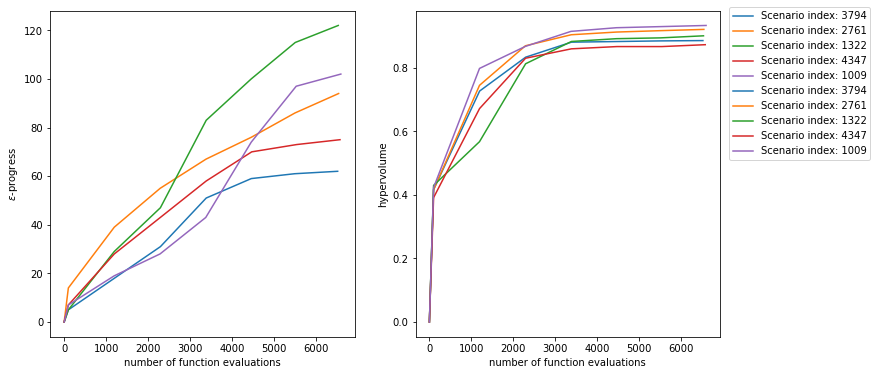

In [19]:
# Plot the convergence metrics to check if the algorithm has converged
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(12,6))

for i, con in enumerate(convergence_all):
    ax1.plot(con['nfe'], con['epsilon_progress'], label=f'Scenario index: {indexes_scenarios[i]}')
    ax2.plot(con['nfe'], con['hypervolume'], label=f'Scenario index: {indexes_scenarios[i]}')

ax1.set_ylabel('$\epsilon$-progress')
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
fig.legend(loc='upper right', bbox_to_anchor=(1.08, 0.9))
plt.savefig('../images/MSMORDM_convergence.png')
plt.show()

We analyse the epsilon-progress and hypervolume convergence metrics to track whether the Multi-Scenario MORDM has converged - i.e. no better solutions can be found within the demarcated policy space - to the possible optimum solutions.


We can see that the epsilon-progress has not fully converged while the hypervolume metric has converged. This suggests that the ranges established for the hypervolume metric were adequate. The epsilon-progress hs started to stabilise for some of the scenarios, however, to ensure that no better solutions can be found, the algorithm should be executed with a larger number of funtion evaluation. Given that this is an exercise of trial and error and due to time constraints, we assume the algorithm found the optimized solutions. 